In [10]:
import numpy.random as random
import numpy as np
import pandas as pd
from IPython.core.display_functions import display
import matplotlib.pylab as plt


In [10]:
def generate_data(n=100, mA=[1.0, 0.5], mB=[-1.0, 0.0], sigmaA=0.5, sigmaB=0.5):
    classA = np.vstack((random.randn(1, n) * sigmaA + mA[0],
                        random.randn(1, n) * sigmaA + mA[1],
                        ))
    y_true_A = np.ones((1, n))

    classB = np.vstack((random.randn(1, n) * sigmaB + mB[0],
                        random.randn(1, n) * sigmaB + mB[1],
                        ))
    y_true_B = -np.ones((1, n))

    data = np.concatenate((classA, classB), axis=1)
    y_true = np.concatenate((y_true_A, y_true_B), axis=1)

    data_with_bias = np.vstack((data, np.ones((1, 2 * n))))

    return data_with_bias, y_true


data_with_bias, y_true = generate_data()

display(pd.DataFrame(data_with_bias))
display(pd.DataFrame(y_true))

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,1.892654,1.084616,-0.111777,1.230013,0.235704,0.905172,0.493711,1.594008,1.314981,0.733770,...,-1.254167,-0.338942,-0.760977,-0.962425,-0.104566,-1.197177,-0.948006,-0.829566,-1.658237,-1.353478
1,0.460128,-0.407167,-0.132358,-0.348271,0.443717,0.581203,-0.488681,0.752363,0.746750,0.736333,...,0.244792,0.500727,-0.601116,0.540758,-0.166161,-0.381024,0.728458,0.574250,0.947608,0.254973
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [12]:
def mackey_glass(t, mg_dict, beta=0.2, gamma=0.1, n=10, r=25):
    if t == 0:
        return 1.5
    elif t < 0:
        return 0

    if mg_dict.get(t):
        return mg_dict.get(t)

    t_prev = t - 1

    if not mg_dict.get(t_prev):
        mg_dict[t_prev] = mackey_glass(t_prev, mg_dict)

    mg_t = mg_dict.get(t_prev)

    if not mg_dict.get(t_prev - r):
        mg_dict[t_prev - r] = mackey_glass(t_prev - r, mg_dict)

    mg_tr = mg_dict.get(t_prev - r)

    return mg_t + (beta * mg_tr) / (1 + mg_tr ** n) - gamma * mg_t

mg_dict = {}
for t in range(100):
    mackey_glass(t, mg_dict)

display(mg_dict)

{0: 1.5,
 -25: 0,
 1: 1.35,
 -24: 0,
 2: 1.215,
 -23: 0,
 3: 1.0935000000000001,
 -22: 0,
 4: 0.9841500000000001,
 -21: 0,
 5: 0.885735,
 -20: 0,
 6: 0.7971615000000001,
 -19: 0,
 7: 0.7174453500000001,
 -18: 0,
 8: 0.6457008150000001,
 -17: 0,
 9: 0.5811307335000001,
 -16: 0,
 10: 0.5230176601500001,
 -15: 0,
 11: 0.47071589413500003,
 -14: 0,
 12: 0.42364430472150005,
 -13: 0,
 13: 0.38127987424935006,
 -12: 0,
 14: 0.34315188682441505,
 -11: 0,
 15: 0.30883669814197356,
 -10: 0,
 16: 0.2779530283277762,
 -9: 0,
 17: 0.2501577254949986,
 -8: 0,
 18: 0.22514195294549874,
 -7: 0,
 19: 0.20262775765094887,
 -6: 0,
 20: 0.18236498188585398,
 -5: 0,
 21: 0.1641284836972686,
 -4: 0,
 22: 0.14771563532754173,
 -3: 0,
 23: 0.13294407179478757,
 -2: 0,
 24: 0.1196496646153088,
 -1: 0,
 25: 0.10768469815377793,
 26: 0.10203000657487908,
 27: 0.10461923984132782,
 28: 0.12449165822223743,
 29: 0.1755352416374559,
 30: 0.2642418962622759,
 31: 0.374379535123461,
 32: 0.4814040102411284,
 33: 0.5

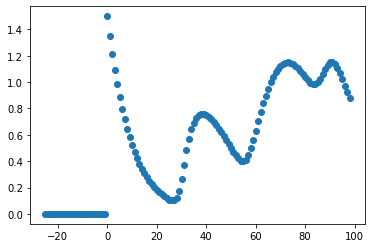

In [13]:
plt.scatter(mg_dict.keys(), mg_dict.values())
plt.show()